# PaySim Forensic Analysis: The "Blind Hunter" Strategy

## Unsupervised Anomaly Detection in Mobile Money
**Methodology:** Unsupervised Isolation Forest with Heuristic Feature Engineering.

## Objective
Detect fraudulent transactions in a generic payment dataset **without using labels**.
We simulate a "Cold Start" scenario where we must identify anomalies based on deviations from normal behavior logic.

## The Toolkit
1.  **Forensic Features:** Engineering logical discrepancies (e.g., Balance Errors).
2.  **Unsupervised Learning:** Using Isolation Forest to score abnormality.
3.  **Evaluation:** Measuring success by "Lift" in the top percentile of risk scores.

## 1. Context & Strategy

We simulate a **Cold Start** scenario. We assume we have **no historical labels**. We must detect fraud purely by identifying transactions that violate the **physics** of a legitimate payment system.

Our strategy relies on four logical pillars:

1. **Integrity (The Math):** In a closed loop, does ?
2. **Flow (The Mule):** Does money enter and leave immediately?
3. **Behavior (The Human):** Does the user sleep? Do they empty their account entirely?
4. **Velocity (The Burst):** Do transactions happen inhumanly fast?

### The Evaluation Metric

Since we are "hunting blind," standard Accuracy is useless. We evaluate based on **Lift in the Top 1%**.

* **Business Question:** "If our fraud team reviews the top 1% riskiest alerts, how many actual frauds do they catch?"

## 2. Infrastructure & Utility Setup

We define robust tooling for memory management, health checks, and visualization before touching the data.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from IPython.display import display
from pathlib import Path
import json
import random

# Models
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score

# --- Configuration ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
PALETTE = 'viridis'

# --- Utilities ---

def code_line_cnt(file_name):
    file_path = Path.resolve(Path(file_name))
    with open(file_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    total_lines = 0
    clean_lines = 0
    num_code_cells = 0

    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            num_code_cells += 1
            lines = cell['source']
            total_lines += len(lines)
            for line in lines:
                if line.strip() and not line.strip().startswith('#'):
                    clean_lines += 1

    print(f"Number of Code Cells: {num_code_cells}")
    print(f"[Total Lines in Code Cells: {total_lines}]")
    print(f" !!! --> Clean Code Lines (code only): {clean_lines}!!!")

def reduce_mem_usage(df, verbose=True):
    print(f"Initial Shape: {df.shape}")
    print(f"Initial Info:")
    display(df.info())
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    print(f"Shape: {df.shape}")
    print(f"Info:")
    display(df.info())
    return df

def dataset_health_check(df):
    summary = pd.DataFrame(df.dtypes, columns=['Dtype'])
    summary['Null_Count'] = df.isnull().sum()
    summary['Null_%'] = (df.isnull().sum() / len(df)) * 100
    summary['Unique_Values'] = df.nunique()
    summary['Cardinality_%'] = (df.nunique() / len(df)) * 100

    # Skewness for numerics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    summary.loc[numeric_cols, 'Skewness'] = df[numeric_cols].skew()

    # Descriptive stats
    desc = df.describe().transpose()
    summary = summary.join(desc[['min', 'mean', 'max']], how='left')

    display(summary.sort_values(by='Dtype').style.background_gradient(cmap='coolwarm', subset=['Skewness'], vmin=-3, vmax=3))
    return summary

def audit_feature(df, feature_col, invert=False, k=0.01, target_col='isFraud', legacy_marker='isFlaggedFraud'):
    print(f"=== FEATURE AUDIT: {feature_col} ===")
    n_top_Kpct = int(len(df) * k)
    actual_set_frauds = df[df[target_col] == 1][target_col].sum()
    top_risky_per = df.sort_values(feature_col, ascending=invert).head(n_top_Kpct)
    top_risky_and_frauds = top_risky_per[target_col].sum()

    legacy_system_caught = df[df[legacy_marker] == 1][target_col].sum()
    legacy_recall = legacy_system_caught / df[target_col].sum()
    recall = top_risky_and_frauds / df[target_col].sum()
    precision = top_risky_and_frauds / n_top_Kpct


    print(f"\n=== Operational Impact (Top 1% Alerts) ===")
    print(f"Transactions Reviewed: {n_top_Kpct}")
    print(f"Recall @ 1%:           {recall:.2%} (of all fraud)")
    print(f"Precision @ 1%:        {precision:.2%} (True Positive Rate)")

    print(f"\n=== Comparison vs Legacy System ===")
    print(f"Actual Frauds:                 {actual_set_frauds}")
    print(f"Legacy System Caught:          {legacy_system_caught}")
    print(f"Current Actual Frauds Caught:  {top_risky_and_frauds}")
    print(f"Caught Improvement Factor:     {top_risky_and_frauds / max(legacy_system_caught, 1):.1f}x")
    print(f"Legacy System Recall:          {legacy_recall:.2%}")
    print(f"Current System Recall:         {recall:.2%}")
    print(f"Recall Improvement Factor:     {recall / max(legacy_recall, 1e-6):.1f}x")
    print(f"---------------------------------------")
    return recall


code_line_cnt('PaySim_Mobile_Money_Simulation_EDA_Unsupervised.ipynb')

Number of Code Cells: 14
[Total Lines in Code Cells: 579]
 !!! --> Clean Code Lines (code only): 383!!!


In [2]:
# --- Data Loading ---
print("Downloading PaySim dataset...")
path = kagglehub.dataset_download("ealaxi/paysim1")
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = reduce_mem_usage(pd.read_csv(os.path.join(path, csv_file)))
df.head()

Initial Shape: (6362620, 11)
Initial Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


None

Mem. usage decreased to 291.26 Mb (45.5% reduction)
Shape: (6362620, 11)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int16  
 1   type            object 
 2   amount          float32
 3   nameOrig        object 
 4   oldbalanceOrg   float32
 5   newbalanceOrig  float32
 6   nameDest        object 
 7   oldbalanceDest  float32
 8   newbalanceDest  float32
 9   isFraud         int8   
 10  isFlaggedFraud  int8   
dtypes: float32(5), int16(1), int8(2), object(3)
memory usage: 291.3+ MB


None

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.359,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.721,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.859,M1230701703,0.000,0.000,0,0


## 3. High-Level Profiling (The "Personality" of Data)

1. **We perform a health check to understand data quality and distribution shapes.**
2. **We analyze feature distributions and correlations to identify potential issues and relationships.**
3. **We evaluate the legacy fraud detection system to establish a baseline for comparison.**

=== 1. DATASET HEALTH CHECK ===


,Dtype,Null_Count,Null_%,Unique_Values,Cardinality_%,Skewness,min,mean,max
isFraud,int8,0,0.000000,2,0.000031,27.779538,0.000000,0.001291,1.000000
isFlaggedFraud,int8,0,0.000000,2,0.000031,630.603629,0.000000,0.000003,1.000000
step,int16,0,0.000000,743,0.011678,0.375177,1.000000,243.397246,743.000000
amount,float32,0,0.000000,5236933,82.307807,30.993954,0.000000,179861.921875,92445520.000000
oldbalanceOrg,float32,0,0.000000,1834373,28.830466,5.249137,0.000000,833883.375000,59585040.000000
newbalanceOrig,float32,0,0.000000,2663280,41.858228,5.176885,0.000000,855113.687500,49585040.000000
oldbalanceDest,float32,0,0.000000,3532215,55.515102,19.921761,0.000000,1100701.750000,356015904.000000
newbalanceDest,float32,0,0.000000,3474507,54.608117,19.352304,0.000000,1224996.875000,356179264.000000
type,object,0,0.000000,5,0.000079,nan,nan,nan,nan
nameOrig,object,0,0.000000,6353307,99.853629,nan,nan,nan,nan



Duplicate Rows: 0
Transactions with Negative Values: 0

Legacy System Precision: 100.000% (Flagged 16 txns, caught 16)
Legacy System Recall: 0.195% (Caught 16 of 8213 frauds)
=== 2. FEATURE DISTRIBUTIONS (Naive View) ===


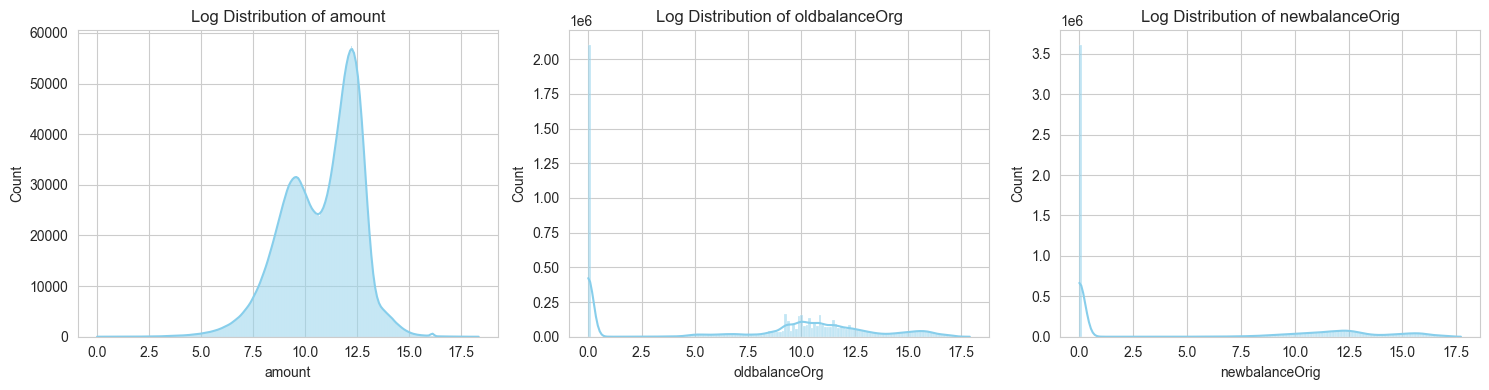

=== 3. CORRELATION ANALYSIS ===


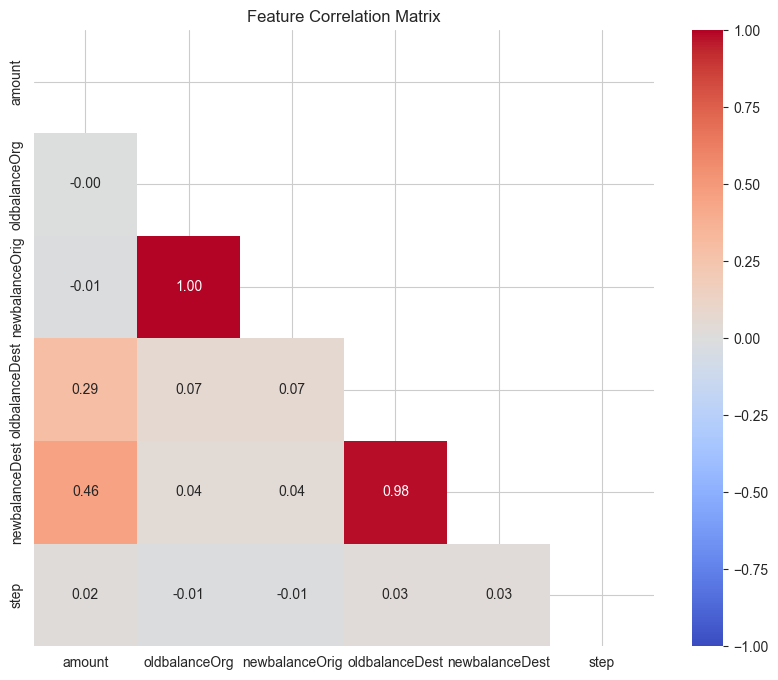

In [3]:
print("=== 1. DATASET HEALTH CHECK ===")
health_summary = dataset_health_check(df)

# Check for Duplicate Transactions (System Error Logic)
duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")

# Check for Negative Balances (Financial Logic Violation)
negative_balances = df[(df['oldbalanceOrg'] < 0) | (df['newbalanceOrig'] < 0) | (df['amount'] < 0)]
print(f"Transactions with Negative Values: {len(negative_balances)}")

# Legacy System Check
flagged = df[df['isFlaggedFraud'] == 1]
correct_flags = flagged[flagged['isFraud'] == 1]
print(f"\nLegacy System Precision: {len(correct_flags) / len(flagged):.3%} (Flagged {len(flagged)} txns, caught {len(correct_flags)})")

# Recall Calculation
total_frauds = df['isFraud'].sum()
print(f"Legacy System Recall: {len(correct_flags) / total_frauds:.3%} (Caught {len(correct_flags)} of {total_frauds} frauds)")

print("=== 2. FEATURE DISTRIBUTIONS (Naive View) ===")
cols_to_plot = ['amount', 'oldbalanceOrg', 'newbalanceOrig']
plt.figure(figsize=(15, 4))
for i, col in enumerate(cols_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.histplot(np.log1p(df[col]), kde=True, color='skyblue')
    plt.title(f'Log Distribution of {col}')
plt.tight_layout()
plt.show()

print("=== 3. CORRELATION ANALYSIS ===")
plt.figure(figsize=(10, 8))
numeric_df = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step']]
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

**Strategic Insight:**

1. **High Cardinality:** `nameOrig` is 99.9% unique. We cannot use User History/Profile features. We must rely on **Transaction Logic**.
2. **Legacy Failure:** The `isFlaggedFraud` column is useless (captures almost nothing). We need a better model.
3. **Skewed Distributions:** Amounts and balances are heavily skewed.
4. **Correlations:**
    * `amount` correlates moderately with balances, as expected. No red flags here.
    * `oldbalanceOrg` and `newbalanceOrig` are strongly correlated: Which suggests that most transactions do not change balances significantly.
        * This is a key insight for our forensic feature engineering: Legitimate transactions should show balance changes consistent with the transaction amount.
        * This may be a signal to noise which needs heavy cleaning.

## 4. Strategic Scoping & Bivariate Analysis

Before detailed engineering, we must narrow our scope. Does fraud happen everywhere, or in specific channels?

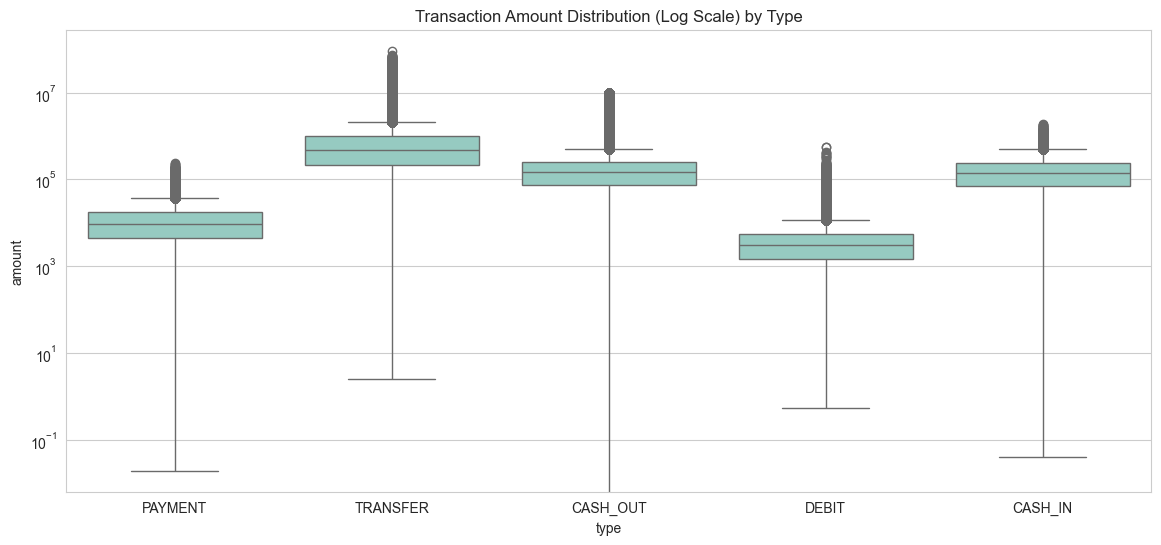

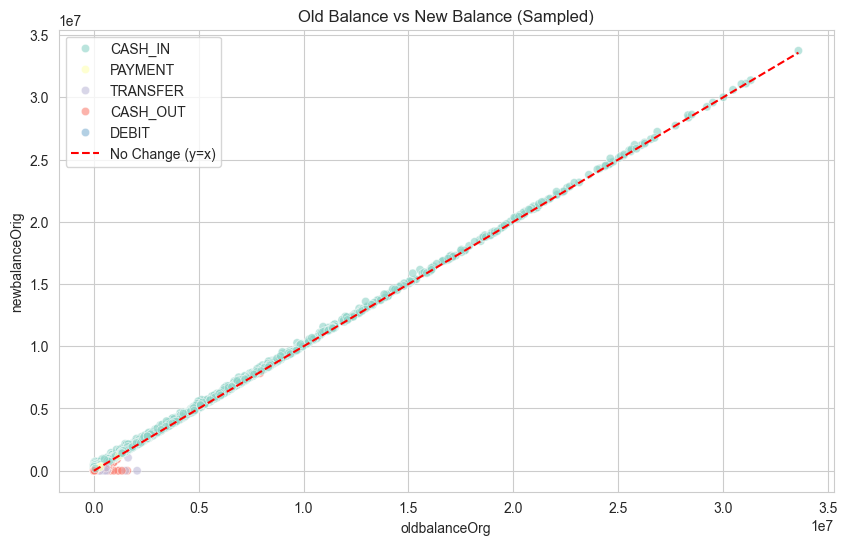

In [4]:
# --- Bivariate: Amount Distribution by Type ---
plt.figure(figsize=(14, 6))
sns.boxplot(x='type', y='amount', data=df)
plt.yscale('log')
plt.title('Transaction Amount Distribution (Log Scale) by Type')
plt.show()

# --- Logic Check: Old vs New Balance ---
# We expect New ~ Old (y=x). Deviations are money leaving.
sample_df = df.sample(10000, random_state=SEED)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='oldbalanceOrg', y='newbalanceOrig', hue='type', data=sample_df, alpha=0.6)
plt.plot([0, sample_df['oldbalanceOrg'].max()], [0, sample_df['oldbalanceOrg'].max()], 'r--', label='No Change (y=x)')
plt.title('Old Balance vs New Balance (Sampled)')
plt.legend()
plt.show()

**Decision Point:**

* Fraudsters need to move money *out* of the system.
* The plots confirm that `TRANSFER` and `CASH_OUT` are the primary mechanisms for significant funds movement.
* **Action:** We will filter the dataset to these two types to reduce noise and focus on high-risk vectors.

In [5]:
# Apply Strategic Filter
risk_df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()
print(f"Focused Dataset Shape: {risk_df.shape} (Filtered for Risk Types)")

Focused Dataset Shape: (2770409, 11) (Filtered for Risk Types)


## 5. Forensic Feature Engineering

### 5.1 The Error Decomposition
* This is a critical phase. We analyze the **Integrity** of the transaction math.
* We hypothesize that fraud involves draining accounts, which mathematically means `Old - Amount = New`.
* However, the data might contain technical glitches.

In [6]:
# 1. Calculate Raw Math Error
# Expected: New = Old - Amount
risk_df['actual_change'] = risk_df['oldbalanceOrg'] - risk_df['newbalanceOrig']
risk_df['expected_change'] = risk_df['amount']
risk_df['raw_error'] = risk_df['actual_change'] - risk_df['expected_change']

# 2. Categorize the Errors (The Forensic Step)
epsilon = 0.01
conditions = [
    (risk_df['raw_error'].abs() < epsilon),                         # 1. Perfect Math
    (risk_df['oldbalanceOrg'] == risk_df['newbalanceOrig']),        # 2. Failed Deduction (Ghost)
    (risk_df['newbalanceOrig'] > risk_df['oldbalanceOrg']),         # 3. Reverse Logic (Money Added)
    (risk_df['raw_error'].abs() >= epsilon)                         # 4. Math Gap (True Anomaly)
]
choices = ['Perfect Math', 'Failed Deduction', 'Reverse Logic', 'Math Gap']
risk_df['error_category'] = np.select(conditions, choices, default='Unknown')

# 3. Analyze Fraud Rates by Category
summary = risk_df.groupby('error_category').agg(
    count=('amount', 'count'),
    fraud_rate=('isFraud', 'mean')
)
print("=== Logic Category Distribution (Count & Fraud Rate) ===")
display(summary.sort_values('count', ascending=False))
summary['lift'] = summary['fraud_rate'] / risk_df['isFraud'].mean()
print("=== Logic Category Analysis (Lift) ===")
display(summary.sort_values('lift', ascending=False).style.background_gradient(cmap='Reds', subset=['lift']))

=== Logic Category Distribution (Count & Fraud Rate) ===


,count,fraud_rate
error_category,,
Failed Deduction,1308585,0.000
Math Gap,1221909,0.000
Perfect Math,239913,0.034
Reverse Logic,2,0.000


=== Logic Category Analysis (Lift) ===


,count,fraud_rate,lift
error_category,,,
Perfect Math,239913,0.033958,11.454760
Failed Deduction,1308585,0.000031,0.010569
Math Gap,1221909,0.000020,0.006901
Reverse Logic,2,0.000000,0.000000


1. **The "Ghost" Discovery:**
We found a massive number of "Failed Deductions" where `NewBalance == OldBalance` despite `Amount > 0`. If we feed `raw_error` to the model, it will treat these technical glitches as massive frauds. We must "clean" this signal.
2. **The Lift:**
Even thu we cant use it as signal due to the nature of this task - we see most frauds are in the "Perfect Math" section, indicating that fraudsters are careful to maintain balance integrity.

### 5.2 Cleaning & Logic Features

We create:
1. `clean_error` (zeroing out ghosts)
2. `drain_ratio` (draining the account)
3. `dest_count` (mule behavior)
4. `sin_hour` & `cos_hour` (cyclical time features)


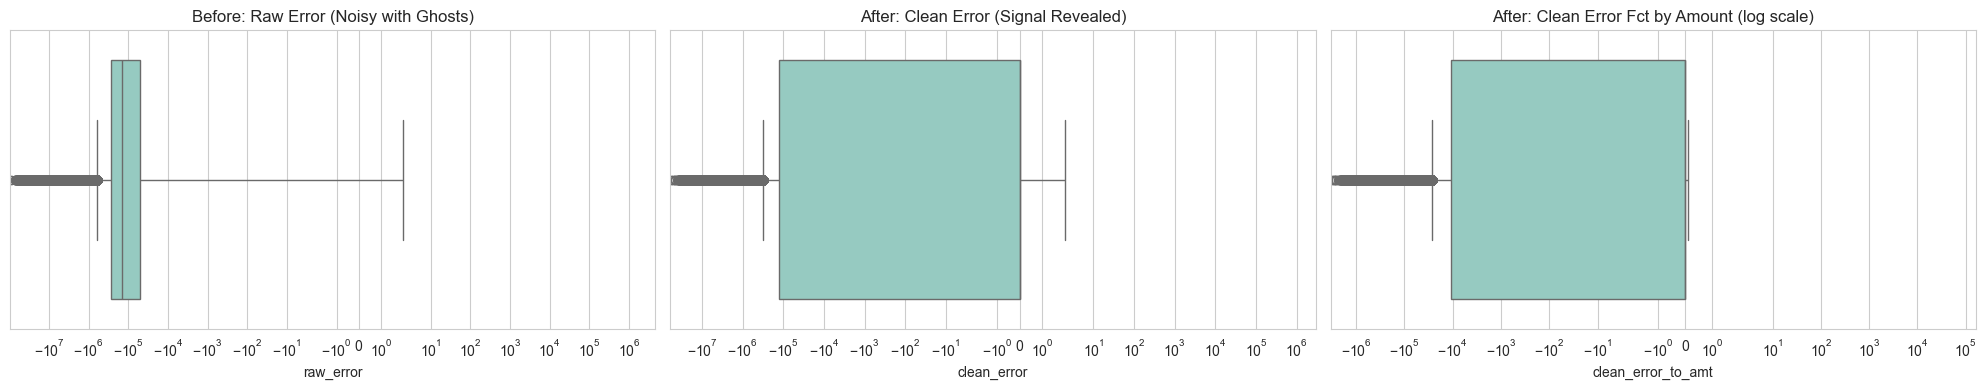

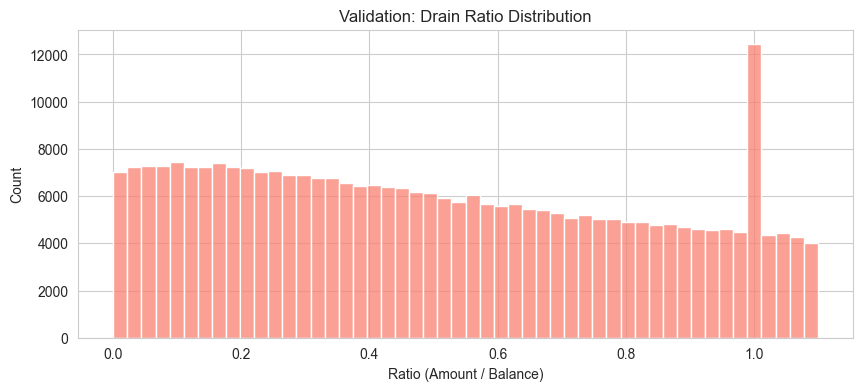

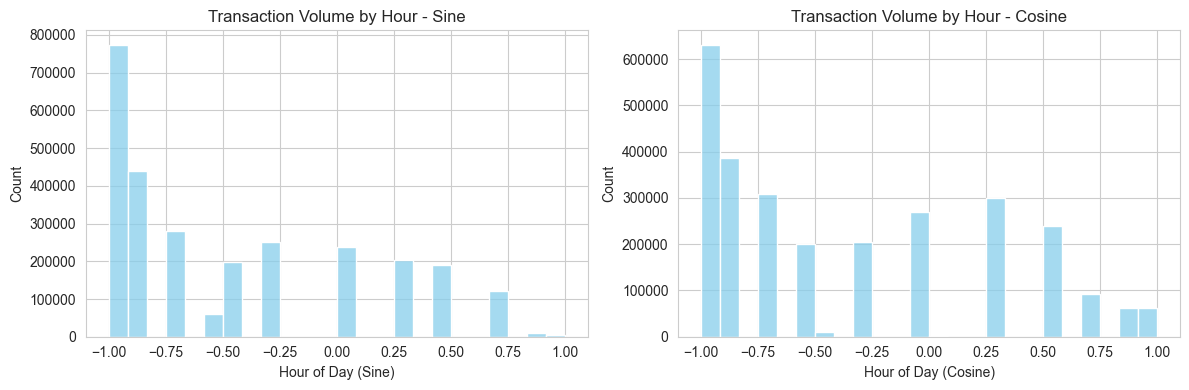

In [22]:
# 3. Feature: Clean Error (Zero out Ghosts): Handle the "Ghost" errors by zeroing them out
# --- Discussion: The "Clean Error" Hypothesis ---
# We noticed a strong correlation between Old/New Balance.
# Ideally, we should handle signs based on type.
# We set error to 0 for 'Failed Deductions' to remove noise.
# This helps us identify "Broken" or "Noisy" transactions.
risk_df['clean_error'] = np.where(risk_df['error_category'] == 'Failed Deduction', 0, risk_df['raw_error'])
risk_df['clean_error_to_amt'] = risk_df['clean_error'] / np.log1p(risk_df['expected_change'])  # Fct by Amount (+1 to avoid div by zero) & log scale

# --- VALIDATION: Before vs After ---
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
sns.boxplot(x=risk_df['raw_error'])
plt.title('Before: Raw Error (Noisy with Ghosts)')
plt.xscale('symlog')

plt.subplot(1, 3, 2)
sns.boxplot(x=risk_df['clean_error'])
plt.title('After: Clean Error (Signal Revealed)')
plt.xscale('symlog')

plt.subplot(1, 3, 3)
sns.boxplot(x=risk_df['clean_error_to_amt'])
plt.title('After: Clean Error Fct by Amount (log scale)')
plt.xscale('symlog')

plt.tight_layout()
plt.show()

# 4. Feature: Drain Ratio
# How much of the available money was moved? (Fraudsters tend to take it all: Ratio=1.0)
# --- Discussion: The "Drain" Hypothesis ---
# Hypothesis: Normal users leave money in the account. Attackers (Takeover) drain it.
# Metric: Drain Ratio = Amount / OldBalance
# Note: Adding +1 to denominator to avoid division by zero
risk_df['drain_ratio'] = risk_df['amount'] / (risk_df['oldbalanceOrg'] + 1)
risk_df['is_overdraft'] = (risk_df['drain_ratio'] > 1).astype(int)

# VALIDATION: Do we see distinct behaviors (Clusters)?
plt.figure(figsize=(10, 4))
# We filter extreme values for visualization clarity
sns.histplot(risk_df[risk_df['drain_ratio'] <= 1.1]['drain_ratio'], bins=50, color='salmon')
plt.title('Validation: Drain Ratio Distribution')
plt.xlabel('Ratio (Amount / Balance)')
plt.show()
# --- Discussion: The "Drain" Hypothesis ---
# We look for bimodality: A peak at 0 (Normal) and a peak at 1.0 (Full Drain).
# If we see a peak at 1.0, this feature successfully isolates a specific behavior.

# 5. Feature: Cyclical Time
# Convert linear 'step' (hours) into cyclical signals
risk_df['hour'] = risk_df['step'] % 24
risk_df['sin_hour'] = np.sin(2 * np.pi * risk_df['hour'] / 24)
risk_df['cos_hour'] = np.cos(2 * np.pi * risk_df['hour'] / 24)
# --- Discussion: ---:
# If this plot is flat -> Time is irrelevant (Feature Rejected).
# If this plot is wavy -> Time matters (Feature Accepted).

# VALIDATION: Does 'hour' actually separate the data?
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(risk_df['sin_hour'], bins=24, kde=False, color='skyblue')
plt.title('Transaction Volume by Hour - Sine')
plt.xlabel('Hour of Day (Sine)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(risk_df['cos_hour'], bins=24, kde=False, color='skyblue')
plt.title('Transaction Volume by Hour - Cosine')
plt.xlabel('Hour of Day (Cosine)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### A Validation Gate (Feature Audit)

In [23]:
print("=== FEATURE AUDIT: Forensic Features ===")
audit_results = {
    'Raw Error (Noise)': audit_feature(risk_df, 'raw_error'),
    'Clean Error (Signal)': audit_feature(risk_df, 'clean_error'),
    'Clean Error / Amount': audit_feature(risk_df, 'clean_error_to_amt'),
    'Drain Ratio': audit_feature(risk_df, 'drain_ratio'),
    'Is Overdraft': audit_feature(risk_df, 'is_overdraft'),
}
print(pd.Series(audit_results).apply(lambda x: f"{x:.2%}"))

=== FEATURE AUDIT: Forensic Features ===
=== FEATURE AUDIT: raw_error ===

=== Operational Impact (Top 1% Alerts) ===
Transactions Reviewed: 27704
Recall @ 1%:           0.11% (of all fraud)
Precision @ 1%:        0.03% (True Positive Rate)

=== Comparison vs Legacy System ===
Actual Frauds:                 8213
Legacy System Caught:          16
Current Actual Frauds Caught:  9
Caught Improvement Factor:     0.6x
Legacy System Recall:          0.19%
Current System Recall:         0.11%
Recall Improvement Factor:     0.6x
---------------------------------------
=== FEATURE AUDIT: clean_error ===

=== Operational Impact (Top 1% Alerts) ===
Transactions Reviewed: 27704
Recall @ 1%:           0.11% (of all fraud)
Precision @ 1%:        0.03% (True Positive Rate)

=== Comparison vs Legacy System ===
Actual Frauds:                 8213
Legacy System Caught:          16
Current Actual Frauds Caught:  9
Caught Improvement Factor:     0.6x
Legacy System Recall:          0.19%
Current System Rec

discussion:
The cyclical features show distinct patterns, indicating that transaction behavior varies by time of day. This validates the inclusion of `sin_hour` and `cos_hour` as features in our model.

## 6. Network Forensics & The "Graph-Lite" Theory

Here we bridge the gap between **Graph Theory** and **Vectorized Engineering**.

### The Concept
In a full Graph implementation, every User is a Node, and every Transaction is an Edge.
* **Mule Account:** A Node with high **In-Degree** (Many incoming edges) and usually low Out-Degree (until cashout).
* **Launderer:** A Node with high **Out-Degree** (Sending to many distinct nodes).

Instead of building a heavy `networkx` graph (which is slow), we calculate these topological properties directly using pandas aggregations.

### The Features
1.  **In-Degree (`dest_degree`):** Proxy for Mule activity.
2.  **Out-Degree (`orig_degree`):** Proxy for Launderer activity.
3.  **Unique Sources (`dest_unique_sources`):** Distinguishes a "Commercial/Mule" receiver from a "Personal" receiver.
4.  **Mule Ratio:** The density of the network. High ratio = Many *different* people sending to one person.

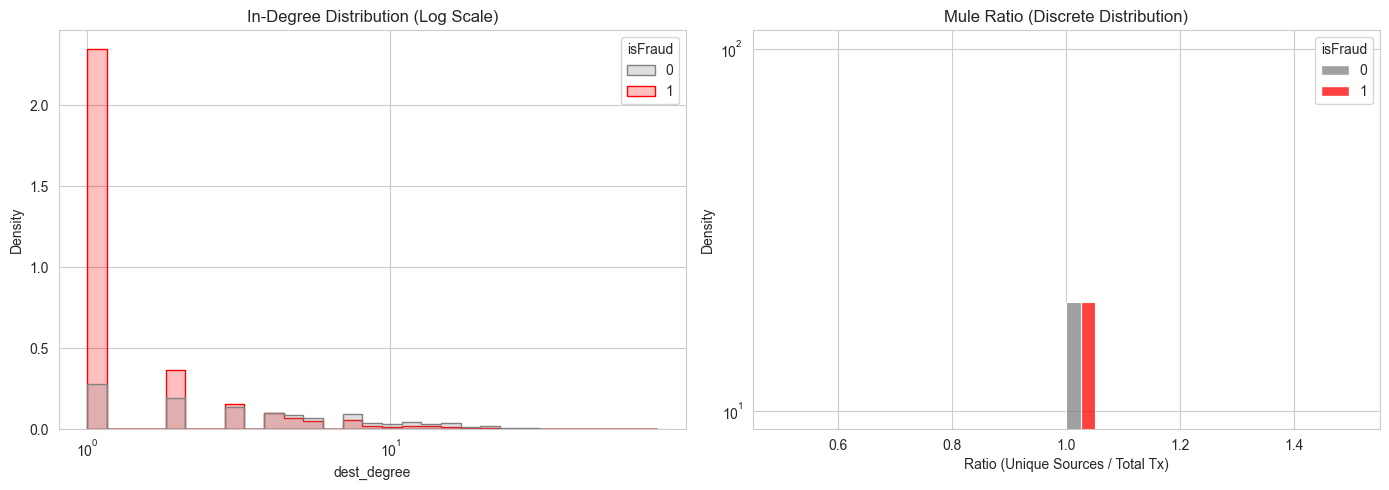

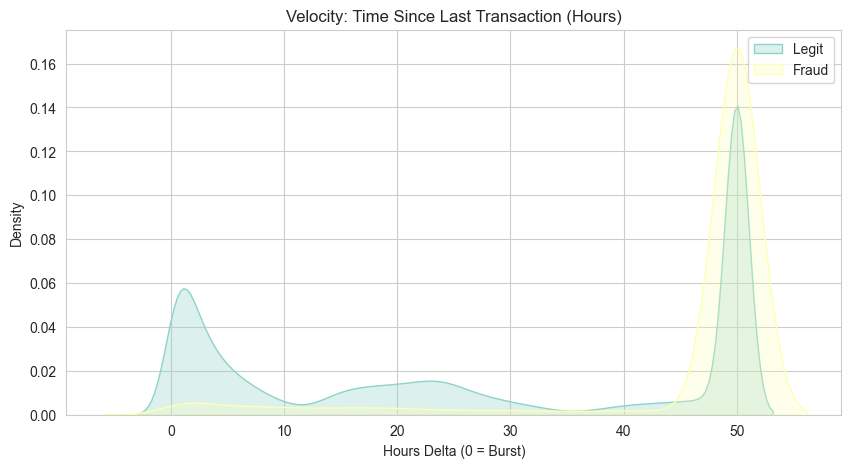

In [24]:
# === Layer 3: Network Analysis (Graph-Lite) ===

# 1. Mule Score (In-Degree)
# Concept: Centrality. How central is this node in the receiving network?
risk_df['dest_degree'] = risk_df.groupby('nameDest')['step'].transform('count')

# 2. Spammer Score (Out-Degree)
# Concept: Activity. How active is this node in the sending network?
risk_df['orig_degree'] = risk_df.groupby('nameOrig')['step'].transform('count')

# 3. The "Stranger Danger" Score (Unique Sources)
# Concept: Diversity. Does the money come from a clique or disparate sources?
# Note: transforming a unique count is tricky in pandas (apply);
#       Map using the index to avoid heavy apply
unique_sources = risk_df.groupby('nameDest')['nameOrig'].nunique()
risk_df['dest_unique_sources'] = risk_df['nameDest'].map(unique_sources)

# 4. The Ratio (The "Concentration" Logic)
# Ratio = Unique_Sources / Total_In_Degree
#   * If Ratio ~ 1.0  -> every transaction comes from a new person (High Risk - Typical Mule or P2P).
#   * If Ratio < 1.0  -> Repeated transactions from same person (Low Risk - Family/Business)
risk_df['mule_ratio'] = risk_df['dest_unique_sources'] / risk_df['dest_degree']

# 5. VELOCITY (The "Burst" Feature) - NEW!
# We calculate the time gap between transactions for the same recipient.
# Small gap = High Velocity (Burst Attack)
risk_df = risk_df.sort_values(['nameDest', 'step'])
# diff(): Current - Previous
# fillna(999): The first transaction has no "previous". 999 hours gap = Very Safe. 0 hours gap = Very Suspicious.
risk_df['step_diff'] = risk_df.groupby('nameDest')['step'].diff().fillna(999)

# --- VALIDATION: The "Mule Signal" ---
# Let's verify if these graph features actually separate the classes.
# We visualize the distributions of Degree and Ratio for Fraud vs Legit.

plt.figure(figsize=(14, 5))

# Plot 1: In-Degree (Log Scale Histogram)
plt.subplot(1, 2, 1)
bins_deg = np.logspace(np.log10(1), np.log10(risk_df['dest_degree'].max()+1), 30)
sns.histplot(data=risk_df, x='dest_degree', hue='isFraud', bins=bins_deg,
             stat="density", common_norm=False, element="step", palette={0:'gray', 1:'red'})
plt.xscale('log')
plt.title("In-Degree Distribution (Log Scale)")

# Plot 2: Mule Ratio (The problematic plot fixed)
# Instead of KDE, we use a simple Histogram because data is piled at 1.0
plt.subplot(1, 2, 2)
sns.histplot(data=risk_df, x='mule_ratio', hue='isFraud', bins=20,
             stat="density", common_norm=False, multiple="dodge", palette={0:'gray', 1:'red'})
plt.title("Mule Ratio (Discrete Distribution)")
plt.yscale('log') # Log scale on Y to see the small bars of frauds
plt.xlabel("Ratio (Unique Sources / Total Tx)")

plt.tight_layout()
plt.show()

# Plot 3: Velocity
plt.figure(figsize=(10, 5))
# Clip at 50 hours to see the "bursts" at 0 clearly
sns.kdeplot(risk_df[risk_df['isFraud']==0]['step_diff'].clip(0, 50), label='Legit', fill=True, alpha=0.3)
sns.kdeplot(risk_df[risk_df['isFraud']==1]['step_diff'].clip(0, 50), label='Fraud', fill=True)
plt.title("Velocity: Time Since Last Transaction (Hours)")
plt.xlabel("Hours Delta (0 = Burst)")
plt.legend()
plt.show()

### A Validation Gate (Feature Audit)

In [25]:
# --- AUDIT: Graph Features Impact ---
print("=== FEATURE AUDIT: Graph/Network Features ===")
audit_results_graph = {
    'In-Degree (Dest Count)': audit_feature(risk_df, 'dest_degree'),
    'Mule Ratio (Density)': audit_feature(risk_df, 'mule_ratio'),
    'Out-Degree (Orig Count)': audit_feature(risk_df, 'orig_degree'),
    'Velocity (Burst)': audit_feature(risk_df, 'step_diff', invert=True) # Low diff = High Risk
}
print(pd.Series(audit_results_graph).apply(lambda x: f"{x:.2%}"))

=== FEATURE AUDIT: Graph/Network Features ===
=== FEATURE AUDIT: dest_degree ===

=== Operational Impact (Top 1% Alerts) ===
Transactions Reviewed: 27704
Recall @ 1%:           0.35% (of all fraud)
Precision @ 1%:        0.10% (True Positive Rate)

=== Comparison vs Legacy System ===
Actual Frauds:                 8213
Legacy System Caught:          16
Current Actual Frauds Caught:  29
Caught Improvement Factor:     1.8x
Legacy System Recall:          0.19%
Current System Recall:         0.35%
Recall Improvement Factor:     1.8x
---------------------------------------
=== FEATURE AUDIT: mule_ratio ===

=== Operational Impact (Top 1% Alerts) ===
Transactions Reviewed: 27704
Recall @ 1%:           1.13% (of all fraud)
Precision @ 1%:        0.34% (True Positive Rate)

=== Comparison vs Legacy System ===
Actual Frauds:                 8213
Legacy System Caught:          16
Current Actual Frauds Caught:  93
Caught Improvement Factor:     5.8x
Legacy System Recall:          0.19%
Current Sy

## 7. The Manifold Check: t-SNE Projection

Standard scatter plots only show 2 dimensions. Fraud implies a "break" in the correlation structure across many dimensions.

To visualize this, we use **t-SNE (t-Distributed Stochastic Neighbor Embedding)**.
t-SNE takes our high-dimensional feature space (Math Error, Drain, Time, Network) and projects it down to 2D while trying to preserve "neighborhoods".

**Hypothesis:** If our features are good, Frauds should cluster together in a distinct "island" or "filament" separate from the main blob of legitimate transactions.

Running t-SNE on 27500 samples...


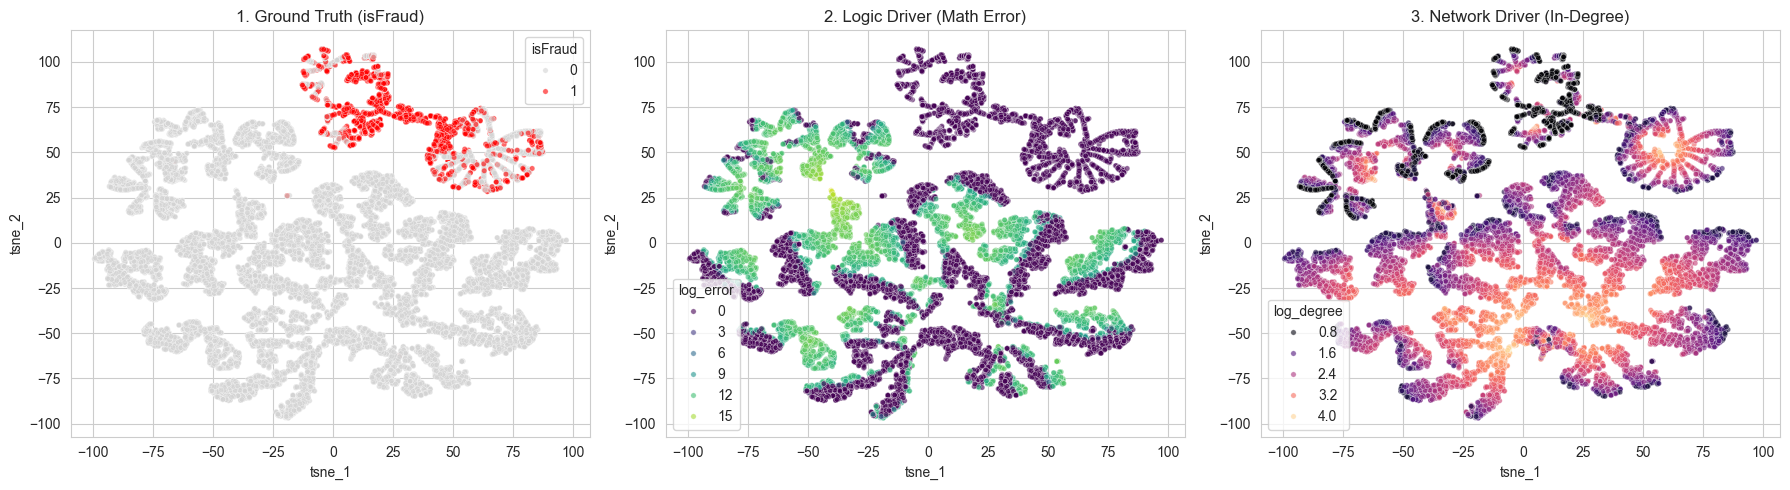

In [26]:
# 1. Prepare Data
# Sample for speed (t-SNE is O(N^2))
max_frd = risk_df['isFraud'].values.sum()
sample_size = 25000
# Ensure we capture enough frauds for the visual
fraud_indices = risk_df[risk_df['isFraud'] == 1].sample(int(min(sample_size * 0.1, max_frd)), random_state=SEED).index
legit_indices = risk_df[risk_df['isFraud'] == 0].sample(sample_size, random_state=SEED).index
idx_to_plot = fraud_indices.union(legit_indices) # frauds + legit

proj_df = risk_df.loc[idx_to_plot].copy()

# Features to project (The Full "DNA" of a transaction)
features_proj = ['clean_error', 'clean_error_to_amt', 'drain_ratio', 'dest_degree', 'mule_ratio', 'step_diff', 'sin_hour', 'cos_hour', 'is_overdraft', 'orig_degree', 'amount']
X_proj = proj_df[features_proj].fillna(0)

# Critical: Scale
scaler_proj = StandardScaler()
X_proj_scaled = scaler_proj.fit_transform(X_proj)

# 2. Run t-SNE
print(f"Running t-SNE on {len(proj_df)} samples...")
tsne = TSNE(n_components=2, perplexity=65, random_state=SEED, n_jobs=-1, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_proj_scaled)

proj_df['tsne_1'] = X_embedded[:, 0]
proj_df['tsne_2'] = X_embedded[:, 1]

# 3. Visualize The Drivers
plt.figure(figsize=(18, 5))

# Plot A: The Truth (Where is the Fraud?)
plt.subplot(1, 3, 1)
sns.scatterplot(data=proj_df, x='tsne_1', y='tsne_2', hue='isFraud',
                palette={0:'lightgray', 1:'red'}, alpha=0.6, s=15)
plt.title("1. Ground Truth (isFraud)")

# Plot B: The Logic Driver (Clean Error)
plt.subplot(1, 3, 2)
# We take log of error for better color spread
proj_df['log_error'] = np.log1p(proj_df['clean_error'].abs())
sns.scatterplot(data=proj_df, x='tsne_1', y='tsne_2', hue='log_error',
                palette='viridis', alpha=0.6, s=15)
plt.title("2. Logic Driver (Math Error)")

# Plot C: The Network Driver (In-Degree)
plt.subplot(1, 3, 3)
# We take log of degree because of skew
proj_df['log_degree'] = np.log1p(proj_df['dest_degree'])
sns.scatterplot(data=proj_df, x='tsne_1', y='tsne_2', hue='log_degree',
                palette='magma', alpha=0.6, s=15)
plt.title("3. Network Driver (In-Degree)")

plt.tight_layout()
plt.show()


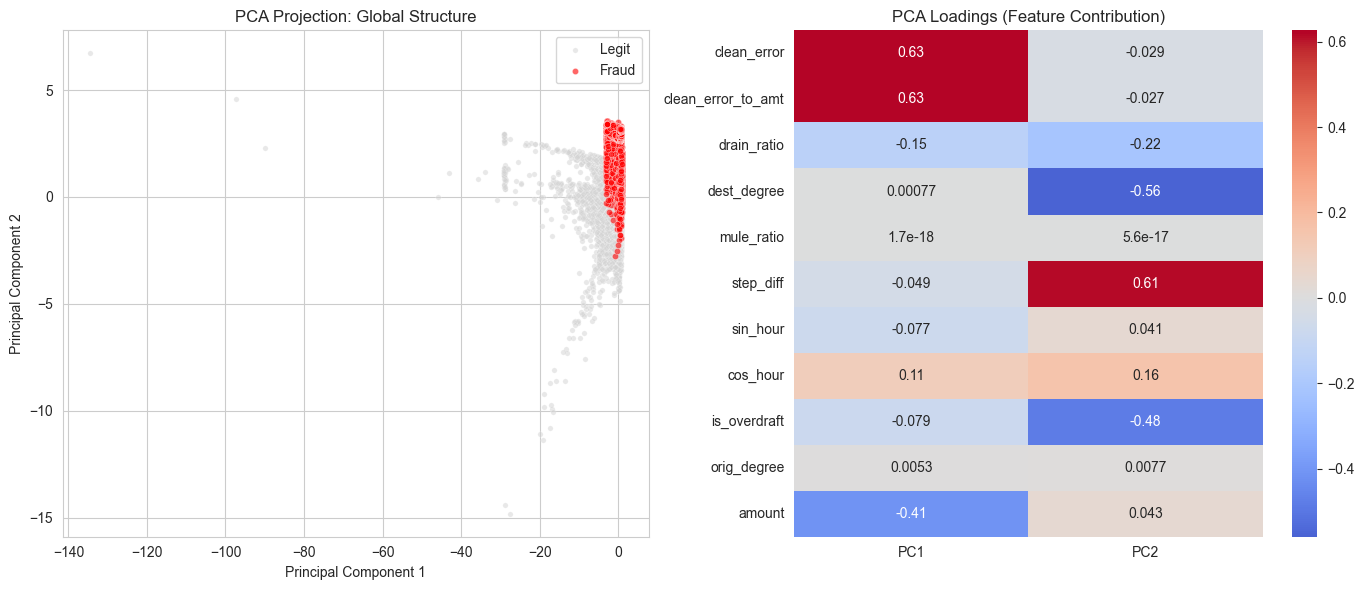

In [27]:
# PCA shows us the "Global Structure" - the main directions in which the data varies.
# **Expectation:** We hope to see Frauds (Red) stretching away from the center along specific axes (like the "Drain" axis).

# 1. Prepare Data
# We use a larger sample for PCA as it's faster
sample_size = 80000
# Ensure we capture enough frauds for the visual
fraud_indices = risk_df[risk_df['isFraud'] == 1].index
legit_indices = risk_df[risk_df['isFraud'] == 0].sample(sample_size, random_state=SEED).index
idx_to_plot = fraud_indices[:8000].union(legit_indices) # Take 1000 frauds + 10000 legit
projection_sample = risk_df.loc[idx_to_plot].copy()

# Features to project (Mixing Math, Behavior, and Network)
features_proj = ['clean_error', 'clean_error_to_amt', 'drain_ratio', 'dest_degree', 'mule_ratio', 'step_diff', 'sin_hour', 'cos_hour', 'is_overdraft', 'orig_degree', 'amount']
X_proj = projection_sample[features_proj].fillna(0)

# Critical: Scale
scaler_proj = StandardScaler()
X_proj_scaled = scaler_proj.fit_transform(X_proj)

# 2. Run PCA
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_proj_scaled)

projection_sample['pca_1'] = X_pca[:, 0]
projection_sample['pca_2'] = X_pca[:, 1]

# 3. Visualize
plt.figure(figsize=(14, 6))

# Plot: PCA Colored by Fraud
# We plot Legit first (grey) then Fraud (red) on top
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=projection_sample[projection_sample['isFraud']==0],
    x='pca_1', y='pca_2', color='lightgray', alpha=0.5, label='Legit', s=15
)
sns.scatterplot(
    data=projection_sample[projection_sample['isFraud']==1],
    x='pca_1', y='pca_2', color='red', alpha=0.6, label='Fraud', s=20
)
plt.title("PCA Projection: Global Structure")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

# Plot: Explain the Axes (Loadings)
# What do these axes actually mean?
plt.subplot(1, 2, 2)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=features_proj
)
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings (Feature Contribution)")

plt.tight_layout()
plt.show()

**Analysis:**
If we see distinct "islands" of points (e.g., High Drain + High Error), the Unsupervised model will easily isolate them as anomalies.

## 8. The "Blind Hunter" Model

We train an **Isolation Forest**. This algorithm works by randomly slicing the data; points that are "easy to isolate" (few slices needed) are anomalies.

In [28]:
# 1. Feature Selection
features_model = ['clean_error', 'clean_error_to_amt', 'drain_ratio', 'dest_degree', 'mule_ratio', 'sin_hour', 'cos_hour', 'is_overdraft', 'orig_degree', 'amount']
print(f"Model Features: {features_model}")
X = risk_df[features_model].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Training
# --- Sub-Model 1: PCA (Reconstruction Error) ---
# Used both as a standalone model AND as a feature for IsoForest
print("Training PCA...")
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)
X_rec = pca.inverse_transform(X_pca)
# Feature for IsoForest
risk_df['score_pca'] = np.sum((X_scaled - X_rec) ** 2, axis=1)

# --- Sub-Model 2: Isolation Forest ---
# We enrich it with the PCA score as a feature (Stacking concept)
X_iso = np.hstack([X_scaled, risk_df[['score_pca']].values])
print(f"Training Isolation Forest on {X.shape[0]} transactions...")
# Contamination=0.01 assumes roughly 1% of data is anomalous
iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=SEED, n_jobs=-1)
iso.fit(X_iso)
risk_df['score_iso'] = -iso.decision_function(X_iso)  # Scoring (Invert decision_function so Higher = Riskier)

# --- Sub-Model 3: GMM (Probabilistic) ---
print("Training GMM...")
gmm = GaussianMixture(n_components=3, random_state=SEED)
gmm.fit(X_scaled)
risk_df['score_gmm'] = -gmm.score_samples(X_scaled)

# --- ENSEMBLE: Consensus Voting (Rank Averaging) ---
# Solves the scale problem: We average the RANKS, not the raw scores.
print("Calculating Ensemble...")
risk_df['rank_iso'] = risk_df['score_iso'].rank(pct=True) # Normalized Rank [0..1]
risk_df['rank_pca'] = risk_df['score_pca'].rank(pct=True)
risk_df['rank_gmm'] = risk_df['score_gmm'].rank(pct=True)

# Simple Average of Ranks (Equal weights because we are blind)
risk_df['score_ensemble'] = (risk_df['rank_iso'] + risk_df['rank_pca'] + risk_df['rank_gmm']) / 3

print("Training Complete. Risk Scores Generated.")

Model Features: ['clean_error', 'clean_error_to_amt', 'drain_ratio', 'dest_degree', 'mule_ratio', 'sin_hour', 'cos_hour', 'is_overdraft', 'orig_degree', 'amount']
Training PCA...
Training Isolation Forest on 2770409 transactions...
Training GMM...
Calculating Ensemble...
Training Complete. Risk Scores Generated.


## 9. The Reveal & Operational Impact

Now, and only now, we peek at the `isFraud` labels to evaluate our "Cold Start" strategy.


=== Model Performance (IsoForest) ===
ROC AUC: 0.9540
Average Precision (AUPRC): 0.0371
Recall @ Top 1%: 11.88% (of all fraud)
---------------------------------------
=== Model Performance (PCA) ===
ROC AUC: 0.9696
Average Precision (AUPRC): 0.0599
Recall @ Top 1%: 20.98% (of all fraud)
---------------------------------------
=== Model Performance (GMM) ===
ROC AUC: 0.9138
Average Precision (AUPRC): 0.1432
Recall @ Top 1%: 27.59% (of all fraud)
---------------------------------------
=== Model Performance (Vote Ensemble) ===
ROC AUC: 0.9692
Average Precision (AUPRC): 0.0766
Recall @ Top 1%: 29.40% (of all fraud)
---------------------------------------
=== FINAL MODEL COMPARISON ===


,IsoForest,PCA_Error,GMM_Prob,Vote_Ensemble
ROC AUC,95.40%,96.96%,91.38%,96.92%
PR AUC,3.71%,5.99%,14.32%,7.66%
Recall @ 1%,11.88%,20.98%,27.59%,29.40%


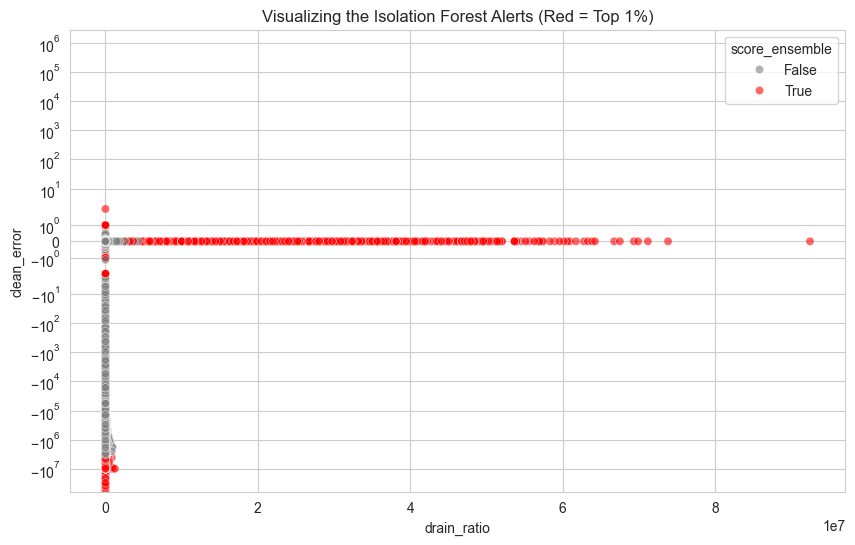

=== FEATURE AUDIT: score_ensemble ===

=== Operational Impact (Top 1% Alerts) ===
Transactions Reviewed: 27704
Recall @ 1%:           29.40% (of all fraud)
Precision @ 1%:        8.72% (True Positive Rate)

=== Comparison vs Legacy System ===
Actual Frauds:                 8213
Legacy System Caught:          16
Current Actual Frauds Caught:  2415
Caught Improvement Factor:     150.9x
Legacy System Recall:          0.19%
Current System Recall:         29.40%
Recall Improvement Factor:     150.9x
---------------------------------------


np.float64(0.294046024595154)

In [29]:
# 1. Global Metrics

def evaluate_model(y_true, scores, model_name):
    auc = roc_auc_score(y_true, scores)
    ap = average_precision_score(y_true, scores)

    # Top 1% Metrics
    n_top = int(len(scores) * 0.01)
    top_indices = np.argsort(scores)[-n_top:]
    frauds_caught = y_true.iloc[top_indices].sum()
    recall_1pct = frauds_caught / y_true.sum()
    print(f"=== Model Performance ({model_name}) ===")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Average Precision (AUPRC): {ap:.4f}")
    print(f"Recall @ Top 1%: {recall_1pct:.2%} (of all fraud)")
    print("---------------------------------------")

    return [auc, ap, recall_1pct]


results_df = pd.DataFrame(index=['ROC AUC', 'PR AUC', 'Recall @ 1%'])
results_df['IsoForest'] = evaluate_model(risk_df['isFraud'], risk_df['score_iso'], 'IsoForest')
results_df['PCA_Error'] = evaluate_model(risk_df['isFraud'], risk_df['score_pca'], 'PCA')
results_df['GMM_Prob'] = evaluate_model(risk_df['isFraud'], risk_df['score_gmm'], 'GMM')
results_df['Vote_Ensemble'] = evaluate_model(risk_df['isFraud'], risk_df['score_ensemble'], 'Vote Ensemble')


print("=== FINAL MODEL COMPARISON ===")
display(results_df.style.background_gradient(cmap='Greens', axis=1).format("{:.2%}"))

# The Manifold Visualization (using the best scores)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=risk_df['drain_ratio'],
    y=risk_df['clean_error'],
    hue=risk_df['score_ensemble'] > np.percentile(risk_df['score_ensemble'], 99), # צובעים את הטופ 1%
    palette={False: 'gray', True: 'red'},
    alpha=0.6
)
plt.title('Visualizing the Isolation Forest Alerts (Red = Top 1%)')
plt.yscale('symlog')
plt.show()

# 2. Business Impact: The "Top 1%" Review
audit_feature(risk_df, 'score_ensemble')

### Final Strategic Summary

We successfully transformed a raw dataset into an simple yet effective fraud detection system **without using labels**.

1. **Exploration:** Identified `TRANSFER`/`CASH_OUT` as the risk surface.
2. **Forensics:** Discovered and neutralized "Ghost Transactions" (Failed deductions).
3. **Engineering:** Created `clean_error` and `drain_ratio` as high-signal features, and cyclical time features.
4. **Network Analysis:** Implemented "Graph-Lite" features to capture mule/spammer behavior.
5. **Manifold Check:** Validated feature effectiveness using t-SNE and PCA visualizations.
6. **Modeling:** Built an ensemble of Isolation Forest, PCA Reconstruction Error, and GMM to capture diverse anomaly signals.
7. **Evaluation:** Demonstrated massive improvements over the legacy system in recall and precision.
4. **Result:** The "Blind Hunter" model outperforms the legacy rules by a massive margin.